# BIBLIOTECAS

In [1]:
# =============================
# script para testes

# Made by: Lucas da Silva Menezes
# 31/07/2023
# =============================

# IMPORTS
import pandas as pd
import matplotlib.pyplot as plt

# import locais
from scripts.calc import *
import scripts.cooling_rate as cooling_rate


**Funções**

In [4]:
def read_profile(file_path):
	# lendo o arquivo do perfil tropical
	df = pd.read_csv(
		file_path,
		sep = ',',
		converters = dict(
			pres = lambda x: pd.to_numeric(x, errors = 'coerce'),
			air_density = lambda x: pd.to_numeric(x, errors = 'coerce'),
			water_density = lambda x: pd.to_numeric(x, errors = 'coerce'),
			ozone_density = lambda x: pd.to_numeric(x, errors = 'coerce')
		)
	)

	# COLUNA | UNIDADE | DESCRICAO
	# hght | km | altitude
	# pres | mb | Pressão atmosférica
	# temp | K | Temperatura do ar
	# air_density | g / m³ | Densidade da parcela de ar úmido
	# water_density | g / m³ | Densidade do vapor d'água na parcela
	# ozone_density | g / m³ | Densidade do ozonio na parcela

	# Calcula a razao de mistura | Adimensional
	df['mixr'] = df['water_density'] / (df["air_density"] - df['water_density'])

	# Converte a altitude de [km] para [m]
	df['hght'] *= 1e3

	# Calcula o path length do vapor d'agua [g / cm²]
	df['u'] = path_length(df['water_density'].values, df['hght'].values)
	df['u'] = df['u'] * 1e-4 # converte de g / m² para g / cm²
	
	return df

In [5]:
# df = wyoming_read(r".\Dados\sbgl_00z_06ago23.txt")
df = read_profile(r".\Dados\tropical.csv")
df

,hght,pres,temp,air_density,water_density,ozone_density,mixr,u
0,0.0,1013.0000,300,1167.0000,1.900000e+01,5.600000e-05,0.016551,4.198211e+00
1,1000.0,904.0000,294,1064.0000,1.300000e+01,5.600000e-05,0.012369,2.598211e+00
2,2000.0,805.0000,288,968.9000,9.300000e+00,5.400000e-05,0.009692,1.483211e+00
3,3000.0,715.0000,284,875.6000,4.700000e+00,5.100000e-05,0.005397,7.832112e-01
4,4000.0,633.0000,277,795.1000,2.200000e+00,4.700000e-05,0.002775,4.382112e-01
5,5000.0,559.0000,270,719.9000,1.500000e+00,4.500000e-05,0.002088,2.532112e-01
6,6000.0,492.0000,264,650.1000,8.500000e-01,4.300000e-05,0.001309,1.357112e-01
7,7000.0,432.0000,257,585.5000,4.700000e-01,4.100000e-05,0.000803,6.971123e-02
8,8000.0,378.0000,250,525.8000,2.500000e-01,3.900000e-05,0.000476,3.371123e-02
9,9000.0,329.0000,244,470.8000,1.200000e-01,3.900000e-05,0.000255,1.521123e-02


**Cooling rate (sem nuvens)**

In [6]:
# ------------- SIGLAS -------------
# cr = cooling rate

# nc = no clouds

# rot = rotational
# cont = continuum
# vib = vibrational
# all =  all bands (rot + cont + vib)

modelo = cooling_rate.CoolingRate(
    T = df['temp'].values,
    u = df['u'].values,
    q = df['mixr'].values,
    p = df['pres'].values,
    Qv = df['water_density'].values * 1e-3 # [kg / m^3]
    ) 

# Taxa de resfriamento [K / day]
df['cr_nc_rot'] = modelo.clear_sky(band = 'rot')
df['cr_nc_cont'] = modelo.clear_sky(band = 'cont')
df['cr_nc_vib'] = modelo.clear_sky(band = 'vib')
df['cr_nc_all'] = modelo.clear_sky(band = 'all')

d:\Lucas\Mestrado\Disciplinas\Radiacao Solar Terrestre\Rad-PPGM\scripts\broadband.py:368: RuntimeWarning: invalid value encountered in sqrt
  termo_raiz = np.sqrt(1 + 1.66 * u * Rw1 / Rw2)


**Figura**

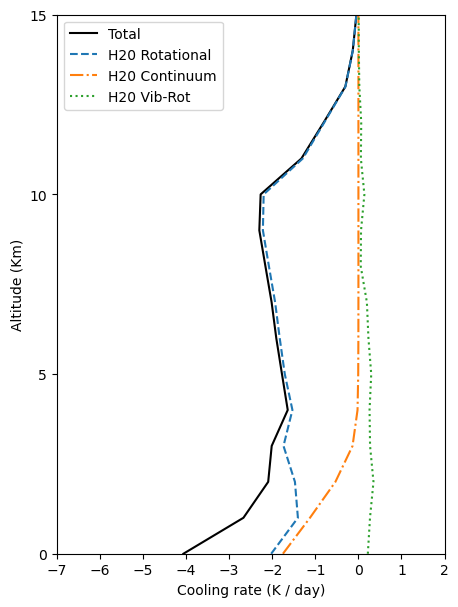

In [8]:
fig, ax  = plt.subplots(figsize = (5, 7))

ax.plot(df['cr_nc_all'], df['hght'] * 1e-3, linestyle = 'solid', color = 'k', label = 'Total')
ax.plot(df['cr_nc_rot'], df['hght'] * 1e-3, linestyle =  'dashed', label = 'H20 Rotational')
ax.plot(df['cr_nc_cont'], df['hght'] * 1e-3, linestyle = 'dashdot', label = 'H20 Continuum')
ax.plot(df['cr_nc_vib'], df['hght'] * 1e-3, linestyle = 'dotted', label = 'H20 Vib-Rot')

# Eixo Y
ax.set_ylim(0, 15)
ax.set_yticks([0, 5, 10, 15])

# Eixo X
left, right = ax.get_xlim()
ax.set_xticks(np.arange(-20, 20, 1))
ax.set_xlim(-7, 2)

# Textos
ax.set_ylabel("Altitude (Km)")
ax.set_xlabel("Cooling rate (K / day)")

# Legenda
plt.legend()

plt.show()

**Cooling rate (com nuvem)**

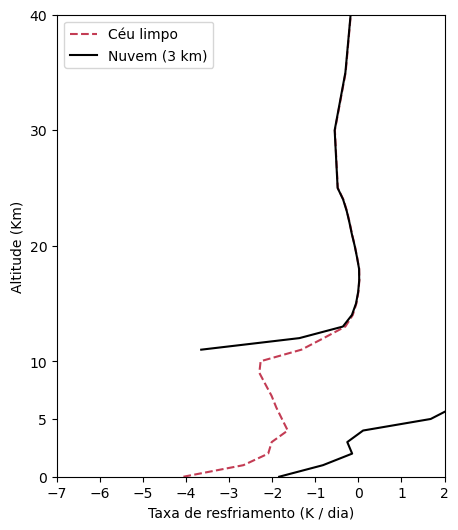

In [13]:
# ------------- SIGLAS -------------
# cr = cooling rate

# nc = no clouds

# rot = rotational
# cont = continuum
# vib = vibrational
# all =  all bands (rot + cont + vib)


# Taxa de resfriamento [K / day]
df['cr_cloud_all'] = modelo.cloudy_atmosphere(
	band = 'all', # Todas as bandas
	Ecb = 0.9876, # Emissividade da base da nuvem
	Ect = 0.9876, # Emissividade do topo da nuvem
	Rc = 0.2401, # Refletividade da nuvem
	Tc = 0, # Transmissividade da nuvem
	Ncb = 7, # Indice (nivel) na sondagem onde a base da nuvem esta
	Nct= 10, # Indice (nivel) na sondagem onde o topo da nuvem esta
	)

# Figura
fig, ax  = plt.subplots(figsize = (5, 6))

ax.plot(df['cr_nc_all'], df['hght'] * 1e-3, '--', color = '#C33C54', label = 'Céu limpo')
ax.plot(df['cr_cloud_all'], df['hght'] * 1e-3, '-', color = 'k', label = 'Nuvem (3 km)')

# Eixo Y
ax.set_ylim(0, 40)
ax.set_yticks([0, 5, 10, 20, 30, 40])

# Eixo X
ax.set_xticks(np.arange(-20, 20, 1))
ax.set_xlim(-7, 2)

# Textos
ax.set_ylabel("Altitude (Km)")
ax.set_xlabel("Taxa de resfriamento (K / dia)")

plt.legend()
plt.show()